# Evaluation des performances de différents modèles

## Import lib et data

In [1]:
# Classique
import pandas as pd
import numpy as np
import re
import joblib
import time
import random
from collections import Counter

# Lime
from lime import lime_tabular

# Visu
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
pd.set_option('display.max_columns', None)

# utils
import utils

# MLFlow
import mlflow
from mlflow.models.signature import infer_signature
import mlflow.sklearn

# SKlearn
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, GridSearchCV, \
                                    StratifiedKFold, LearningCurveDisplay
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, \
                            precision_score, recall_score, make_scorer, \
                            average_precision_score, f1_score, fbeta_score, \
                            accuracy_score
from sklearn.linear_model import LogisticRegression

# ImbLearn (SMOTE)
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.pipeline import make_pipeline, Pipeline

# LightGBM
from lightgbm import LGBMClassifier

---

## Séparation des données

In [2]:
train_df = pd.read_csv('Data/train.csv')
feats = [f for f in train_df.columns if f not in 
         ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = train_df[feats]
y = train_df['TARGET']

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y,
                                                    train_size = 0.8,
                                                    random_state = 42)

In [4]:
print('Shape of training set')
print('X_train : {}'.format(X_train.shape))
print('y_train : {}'.format(y_train.shape))
print('ratio TARGET : ', y_train.value_counts(normalize=True).values)
print('------------------------')
print('Shape of test set')
print('X_test : {}'.format(X_test.shape))
print('y_test : {}'.format(y_test.shape))
print('ratio TARGET : ',y_test.value_counts(normalize=True).values)

Shape of training set
X_train : (245990, 200)
y_train : (245990,)
ratio TARGET :  [0.91927314 0.08072686]
------------------------
Shape of test set
X_test : (61498, 200)
y_test : (61498,)
ratio TARGET :  [0.91926567 0.08073433]


In [5]:
idx = random.randint(1, len(X_test))
data_test = X_train.iloc[[idx]]
data_test.to_csv('flask_application/data_test.csv')

## Pré-traitement des données

### Imputations et Scaling

In [6]:
num_features = make_column_selector(dtype_include = ['float64'])

pipe_num = Pipeline([
    ("impnum", SimpleImputer(strategy = 'median')),
    ("sc", StandardScaler()),
])

cat_features = make_column_selector(dtype_exclude = ['float64'])
pipe_cat = Pipeline([
    ("impcat", SimpleImputer(strategy = 'most_frequent'))
])

preprocessor = make_column_transformer((pipe_num, num_features),
                                       (pipe_cat, cat_features))


### Traitement désequilibre des classes

In [7]:
over_sampler = SMOTE(random_state=42)

under_sampler = RandomUnderSampler(random_state=42)

## Définition des scores utilisés pour évaluer nos modèles

In [8]:
scoring = {'AUC' : 'roc_auc',
           'AP_score' : make_scorer(average_precision_score,needs_proba=True),
           'f1_score' : 'f1',
           'f10_score' : make_scorer(fbeta_score, beta=10),
           'accuracy' : 'accuracy'
          }

# Logistic Regression

## Sélection hyperparamètres avec GridSearch

In [9]:
pipeline = Pipeline([
    ('imputer_scaler', preprocessor),
    ('over', over_sampler),
    ('under', under_sampler),
    ('estimator',  LogisticRegression(tol=0.1))
])

param_grid = {
    "estimator__C": [0.001, 0.002],
    "estimator__max_iter": [200, 300],
    "estimator__solver": ["newton-cholesky", 'lbfgs'],
    "over__sampling_strategy": [0.1, 0.2, 0.5]
}

cv = StratifiedKFold(n_splits=5)
grid = GridSearchCV(pipeline, param_grid=param_grid, cv=cv, scoring=scoring, refit='AUC') # changer refit par auc

In [10]:
print('Entrainement du modèle...')
start = time.time()
grid.fit(X_train, y_train)
end = time.time()
delta = round((end - start), 3)
print('Temps total CV : {}s'.format(delta))

Entrainement du modèle...


C:\Users\julie\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\julie\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Temps total CV : 1266.359s


## Evaluation du modèle

In [11]:
b_score = grid.best_score_
b_params = grid.best_params_
print('Résultat sur le jeu d\'entrainement avec cross-validation')
print('Meilleur score : {}'.format(b_score))
print('Meilleur params : {}'.format(b_params))

Résultat sur le jeu d'entrainement avec cross-validation
Meilleur score : 0.760408289776286
Meilleur params : {'estimator__C': 0.002, 'estimator__max_iter': 200, 'estimator__solver': 'newton-cholesky', 'over__sampling_strategy': 0.1}


In [12]:
cv_results = pd.DataFrame(grid.cv_results_)
cv_results

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        8.672775      0.509012         0.965713        0.112377   
1        9.241025      0.939925         0.956840        0.107853   
2        8.993563      0.374771         0.887315        0.077950   
3        8.356701      0.484639         0.834283        0.062136   
4        9.089086      0.349237         0.897515        0.093443   
5       13.167587      0.335891         0.871722        0.063515   
6        8.291017      0.682370         0.872466        0.069738   
7        8.138885      0.363718         0.819681        0.051855   
8        8.935184      0.251097         0.865772        0.106080   
9        8.458733      0.370324         0.880055        0.091418   
10       9.185761      0.394229         0.873014        0.058961   
11      13.469861      0.367547         0.827149        0.041149   
12       7.883251      0.247261         0.886194        0.081819   
13       8.464963      0.457419         0.837830        0.046253   
14       9.185332      0.448245         0.892228        0.084456   
15       8.265703      0.390092         0.875163        0.097057   
16       9.655509      0.742613         0.850894        0.050941   
17      14.744269      0.807515         0.869995        0.070366   
18       7.875423      0.415065         0.866580        0.079188   
19       8.275183      0.280527         0.869203        0.092065   
20       9.288113      1.152553         0.844279        0.054176   
21       8.285684      0.360116         0.844757        0.077115   
22       9.386460      0.397324         0.840184        0.064171   
23      14.119211      0.399324         0.907194        0.074184   

   param_estimator__C param_estimator__max_iter param_estimator__solver  \
0               0.001                       200         newton-cholesky   
1               0.001                       200         newton-cholesky   
2               0.001                       200         newton-cholesky   
3               0.001                       200                   lbfgs   
4               0.001                       200                   lbfgs   
5               0.001                       200                   lbfgs   
6               0.001                       300         newton-cholesky   
7               0.001                       300         newton-cholesky   
8               0.001                       300         newton-cholesky   
9               0.001                       300                   lbfgs   
10              0.001                       300                   lbfgs   
11              0.001                       300                   lbfgs   
12              0.002                       200         newton-cholesky   
13              0.002                       200         newton-cholesky   
14              0.002                       200         newton-cholesky   
15              0.002                       200                   lbfgs   
16              0.002                       200                   lbfgs   
17              0.002                       200                   lbfgs   
18              0.002                       300         newton-cholesky   
19              0.002                       300         newton-cholesky   
20              0.002                       300         newton-cholesky   
21              0.002                       300                   lbfgs   
22              0.002                       300                   lbfgs   
23              0.002                       300                   lbfgs   

   param_over__sampling_strategy  \
0                            0.1   
1                            0.2   
2                            0.5   
3                            0.1   
4                            0.2   
5                            0.5   
6                            0.1   
7                            0.2   
8                            0.5   
9                            0.1   
10                           0.

Résultat sur le jeu de test avec le meilleur modèle retenu


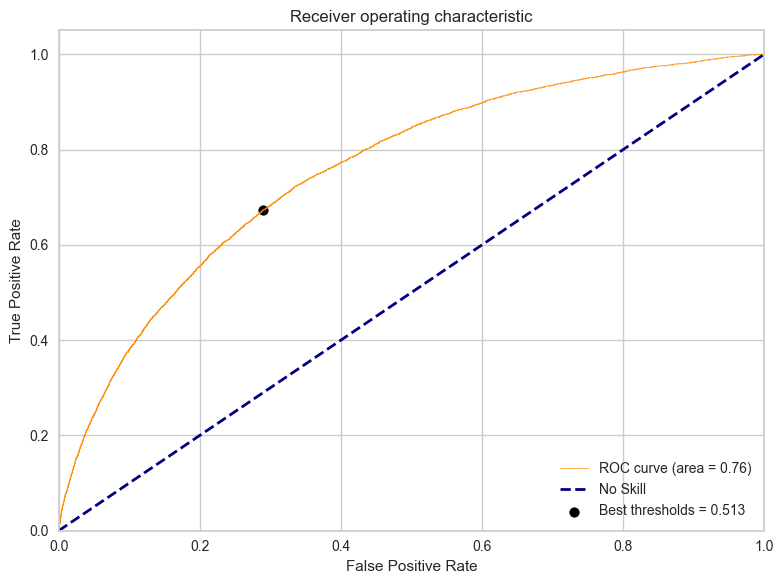

Fbeta score (beta=10), seuil=0.5 : 0.6693487427043601
Fbeta score (beta=10), seuil=0.513 : 0.6541009775394523


In [13]:
predictions = grid.predict_proba(X_test)[:, 1]
preds = grid.predict(X_test)

print('Résultat sur le jeu de test avec le meilleur modèle retenu')
best_thresh = utils.plot_roc_auc(y_test, predictions)

preds_threshed = (grid.predict_proba(X_test)[:, 1] > best_thresh).astype(int)

print('Fbeta score (beta=10), seuil=0.5 : {}'.format(
    fbeta_score(y_test, preds, beta=10)))
print('Fbeta score (beta=10), seuil={} : {}'.format(
    round(best_thresh, 3), fbeta_score(y_test, preds_threshed, beta=10)))

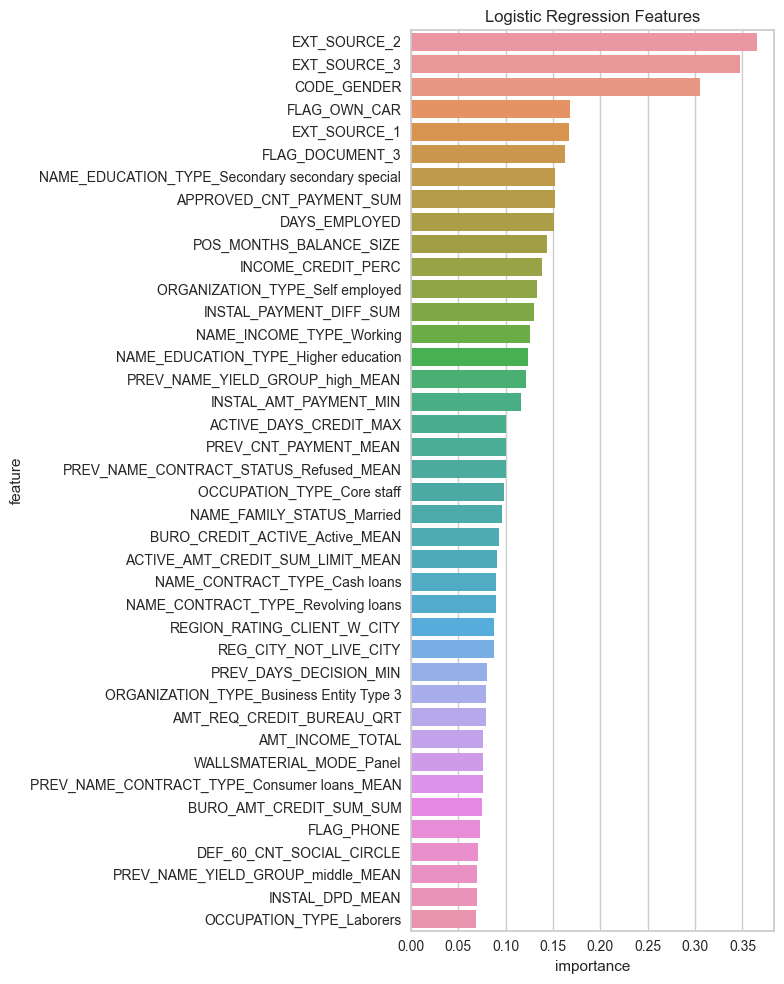

In [14]:
importance_df = pd.DataFrame()

names = grid.best_estimator_.named_steps['imputer_scaler'].get_feature_names_out()
feature_names = []
for name in names:
    name1 = name.replace('pipeline-1__', '')
    name2 = name1.replace('pipeline-2__', '')
    feature_names.append(name2)

importance_df["feature"] = feature_names
importance_df["importance"] = np.abs(grid.best_estimator_['estimator'].coef_[0])

title = 'Logistic Regression Features'
utils.display_importances(importance_df, title)

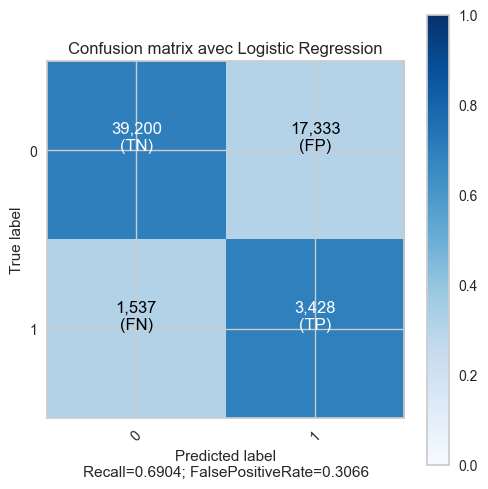

In [15]:
cm = confusion_matrix(y_test, preds)
title = 'Confusion matrix avec Logistic Regression'
utils.plot_confusion_matrix(cm, ['0', '1'], title, normalize=True)

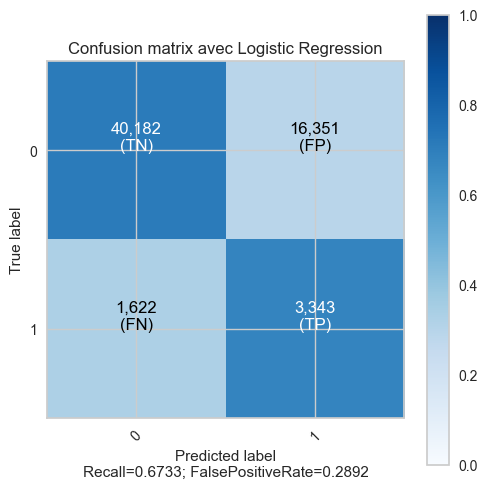

In [16]:
cm = confusion_matrix(y_test, preds_threshed)
title = 'Confusion matrix avec Logistic Regression'
utils.plot_confusion_matrix(cm, ['0', '1'], title, normalize=True)

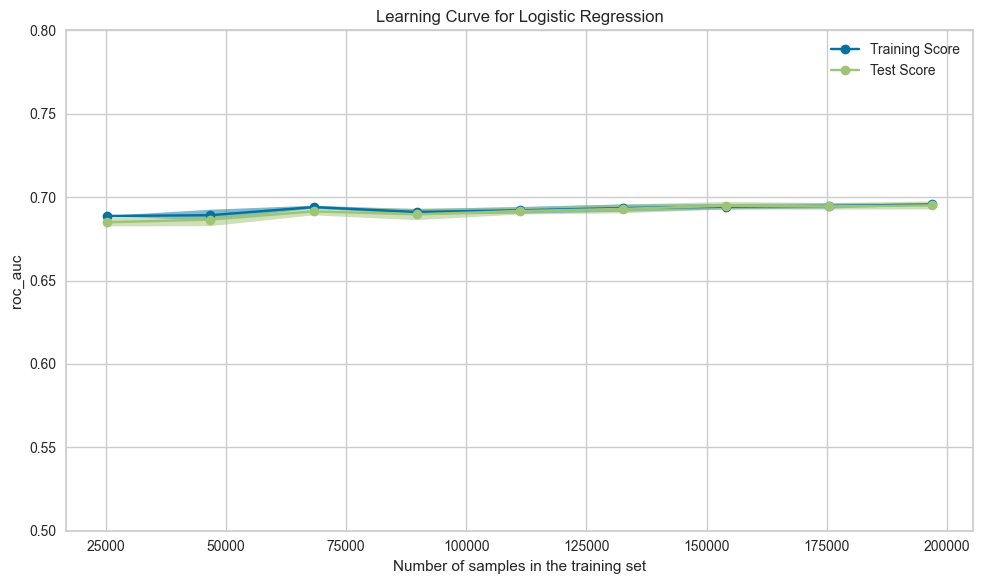

In [17]:
params = dict(**b_params)
estimator = Pipeline([
        ('imputer_scaler', preprocessor),
        ('over', over_sampler),
        ('under', under_sampler),
        ('estimator',  LogisticRegression(tol=0.1))
    ])
estimator.set_params(**params)
utils.plot_learning_curve(X_train, y_train, estimator)

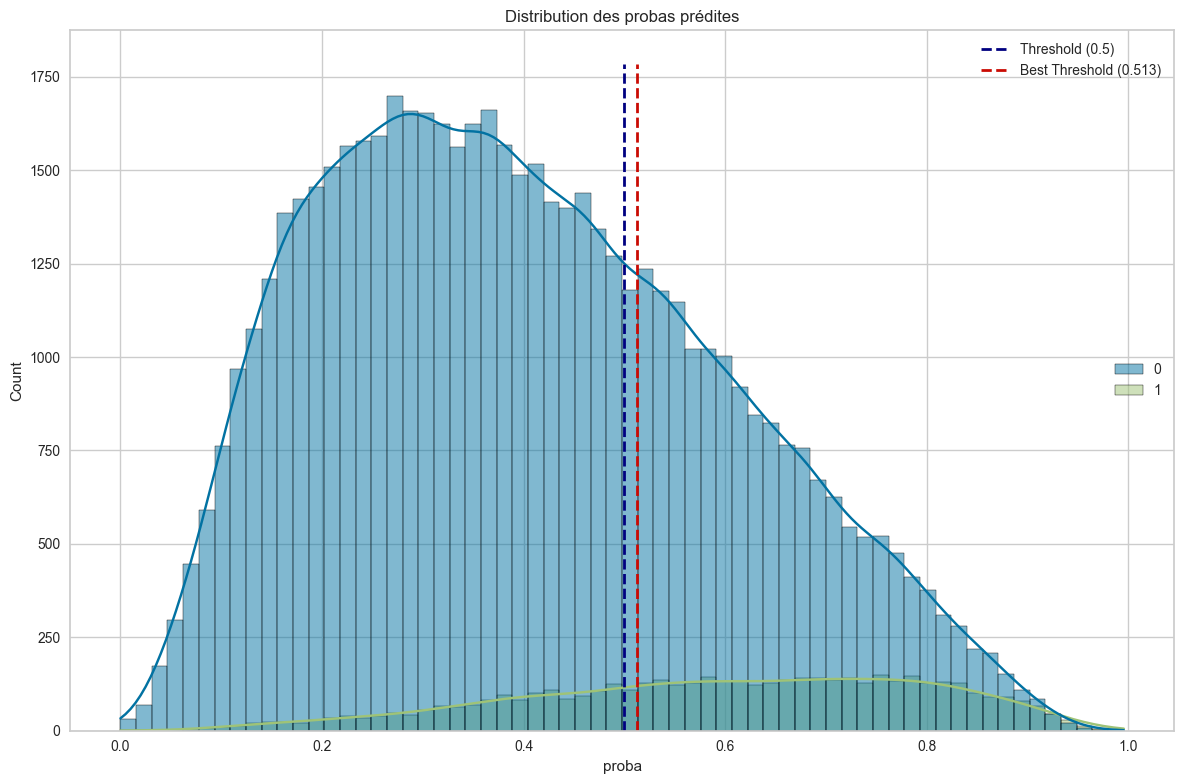

In [18]:
utils.plot_hist_proba(predictions, y_test, best_thresh)

## Enregistrement params/metrics/artefacts avec MLFlow

In [57]:
# Création d'une fonction personnalisée pour effectuer des prédictions en fonction d'un seuil
class CustomModelWrapper(mlflow.pyfunc.PythonModel):
    def __init__(self, model, threshold=0.5):
        self.model = model
        self.threshold = threshold

    def predict(self, context, model_input):
        # Prédiction personnalisée avec le paramètre threshold
        probabilities = self.model.predict_proba(model_input)
        predictions = (probabilities[:, 1] >= self.threshold).astype(int)
        return predictions
    
    def predict_proba(self, model_input, context=None):
        return self.model.predict_proba(model_input)
    
    def model(self, context=None):
        return self.model

C:\Users\julie\anaconda3\lib\site-packages\mlflow\models\signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
C:\Users\julie\anaconda3\lib\site-packages\mlflow\models\signature.py:153: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data con

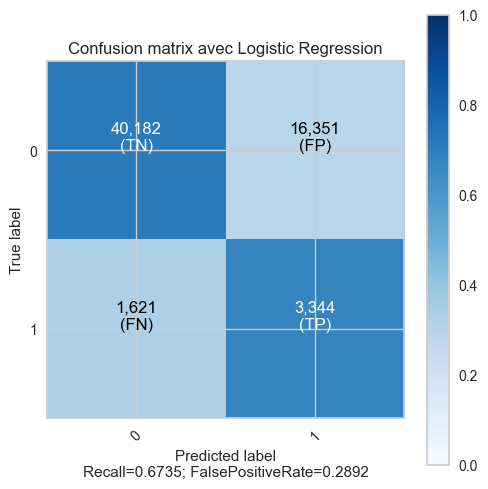

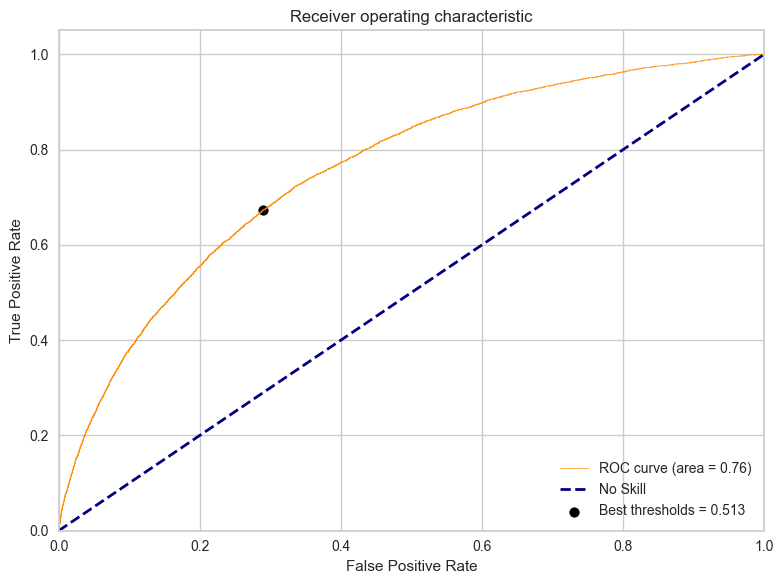

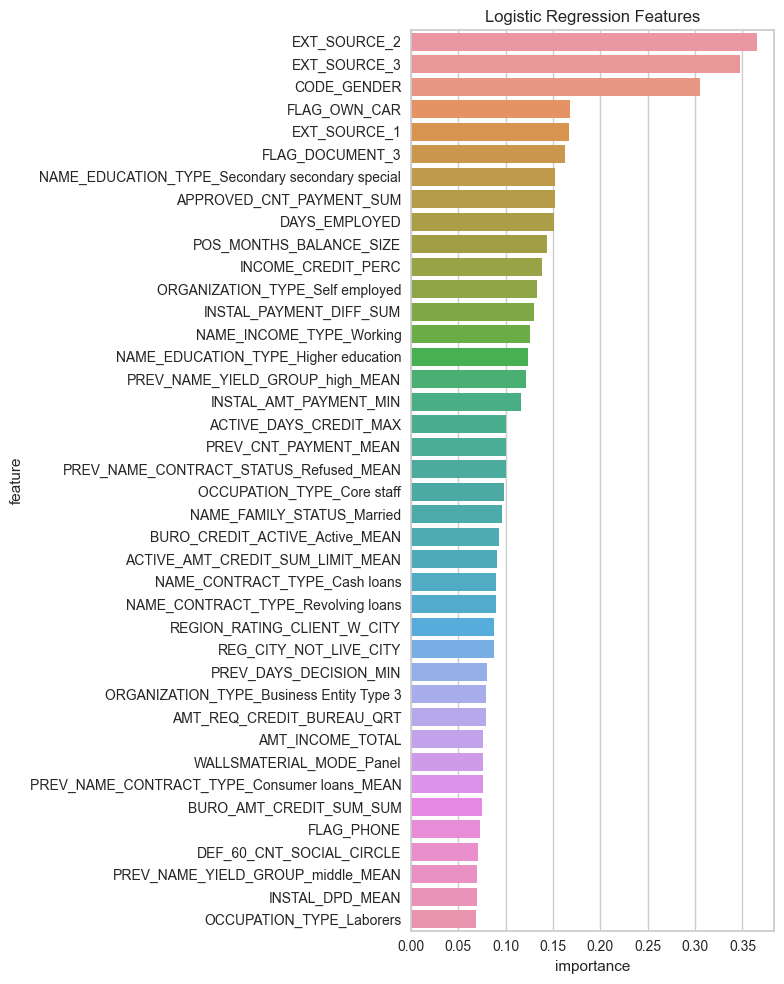

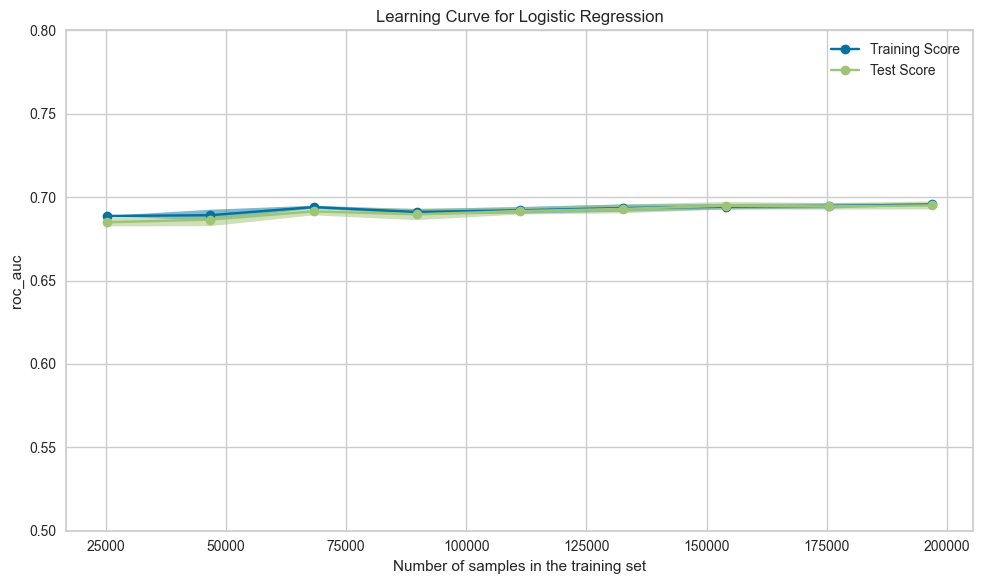

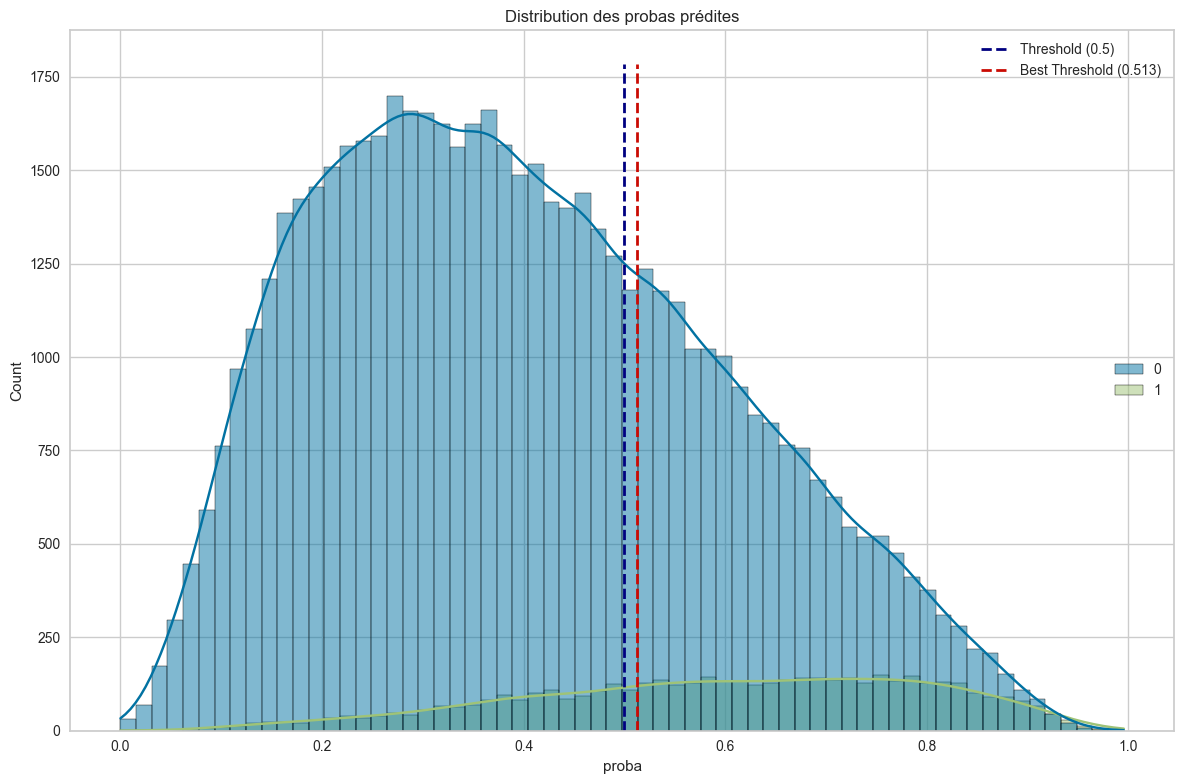

In [58]:
run_description = """
### Data
Dataset complet
Sélection de feature : condition sur la variance
                       Kbest (k=200) basé sur mutual_info_classif
                       corrélation entre variables
Imputation simple : float --> median
                    int   --> most frequent
Standard scaler pour vars continues
Over and under sampling pour gérer déséquilibre de classe

### Modèle
logistic regression paramétrer avec GridSearchCV
Threshold adapté au problème (cout FN = 10 * cout FP)
"""
run_name = 'LogisticRegression_Smote'

with mlflow.start_run(run_name=run_name, description=run_description):

    # Enregistrement de plusieurs paramètres sous forme d'un dictionnaire
    params = {}
    params['MODEL_NAME'] = 'LogisticRegression'
    params['PARAMS_CV'] = b_params
    params['THRESHOLD'] = best_thresh
    params['BETA'] = 10
    params['TRAIN_SIZE'] = len(X_train)
    params['TEST_SIZE'] = len(X_test)
    params['NB_FEATS'] = X_train.shape[1]
    params['SEED'] = 42
    mlflow.log_params(params)

    # On note le moment du début de l'expérience pour mesurer la durée de l'entraînement
    start = time.time()

    # Initialisation du modèle
    params = dict(**b_params)
    pred_pipeline = Pipeline([
        ('imputer_scaler', preprocessor),
        ('over', over_sampler),
        ('under', under_sampler),
        ('estimator',  LogisticRegression(tol=0.1))
    ])
    pred_pipeline.set_params(**params)
    signature = infer_signature(X_train, y_train)

    # Entraînement du modèle
    pred_pipeline.fit(X_train, y_train)

    training_time = time.time() - start

    # # Enregistrement du modèle
    
    # Appliquons le seuil de prédiction souhaité avec fonction personnalisée
    custom_threshold = best_thresh
    custom_model = CustomModelWrapper(pred_pipeline, threshold=custom_threshold)
    
    predictions = custom_model.predict(None, X_test)
    predictions_proba = custom_model.predict_proba(X_test)[:, 1]

    # Enregistrez le modèle avec le seuil ajusté dans MLflow
    mlflow.pyfunc.log_model(
    python_model=custom_model,  
    artifact_path="mlflow_LR_with_threshold",  
    signature=signature
    )
    
    # # Enregistrement du modèle avec joblib
    # joblib.dump(pred_pipeline, 'flask_application/model.joblib')

    # Enregistrement de plusieurs métriques sous forme d'un dictionnaire
    metrics = {}
    metrics['Auc_test'] = roc_auc_score(y_test, predictions_proba)
    metrics['Auc_train'] = roc_auc_score(y_train, custom_model.predict_proba(X_train)[:, 1])
    metrics['Fbeta'] = fbeta_score(y_test, predictions, beta=10)
    metrics['Precision'] = precision_score(y_test, predictions)
    metrics['Recall'] = recall_score(y_test, predictions)
    metrics['Accuracy'] = accuracy_score(y_test, predictions)
    metrics['Training Time'] = training_time
    mlflow.log_metrics(metrics)

    # Enregistrement de la matrice de confusion
    cm = confusion_matrix(y_test, predictions)
    title = 'Confusion matrix avec Logistic Regression'
    utils.plot_confusion_matrix(cm, ['0', '1'], title)
    mlflow.log_artifact('Data/matrix.png')

    # Enregistrement courbe ROC
    utils.plot_roc_auc(y_test, predictions_proba)
    mlflow.log_artifact('Data/roc_auc_curve.png')

    # Enregistrement features importance du modèle
    importance_df = pd.DataFrame()
    importance_df["feature"] = feature_names
    importance_df["importance"] = np.abs(pred_pipeline['estimator'].coef_[0])

    title = 'Logistic Regression Features'
    utils.display_importances(importance_df, title)
    mlflow.log_artifact('Data/features_importances.png')

    # Enregistrement Learning curve
    utils.plot_learning_curve(X_train, y_train, pred_pipeline)
    mlflow.log_artifact('Data/learning_curve.png')
    
    # Enregistrement disribution probas
    utils.plot_hist_proba(predictions_proba, y_test, best_thresh)
    mlflow.log_artifact('Data/distribution_pred_probas.png')
      

## Feature importance with LIME

In [59]:
nb_num_feats = len(X.select_dtypes(include='float64').columns)
nb_total_feats = X.shape[1]
cat_features = list(range(nb_num_feats, nb_total_feats))
class_names = ['accordé', 'refusé']

X_smpl = X.sample(10000)
X_smpl_tr = custom_model.model.named_steps['imputer_scaler'].transform(X_smpl)

lime_data = pd.DataFrame(X_smpl_tr, columns=feature_names)
lime_data.to_csv('flask_application/lime_data.csv', index=False)

explainer = lime_tabular.LimeTabularExplainer(X_smpl_tr, mode="classification",
                                              class_names=class_names,
                                              feature_names=feature_names,
                                              categorical_features=cat_features)

In [60]:
idx = random.randint(1, len(X_test))

In [66]:
X_test_tr = custom_model.model.named_steps['imputer_scaler'].transform(X_test.iloc[[idx]])
X_test_df = pd.DataFrame(X_test_tr, columns=feature_names)
predict_fn = custom_model.model.named_steps['estimator'].predict_proba

pred = custom_model.predict(None, X_test.iloc[[idx]])[0]
print("Prediction : ", class_names[pred])
print("True :     ", class_names[int(y_test.iloc[idx])])

explanation = explainer.explain_instance(X_test_tr[0], predict_fn,
                                         num_features=15)

explanation.show_in_notebook()

Prediction :  refusé
True :      accordé


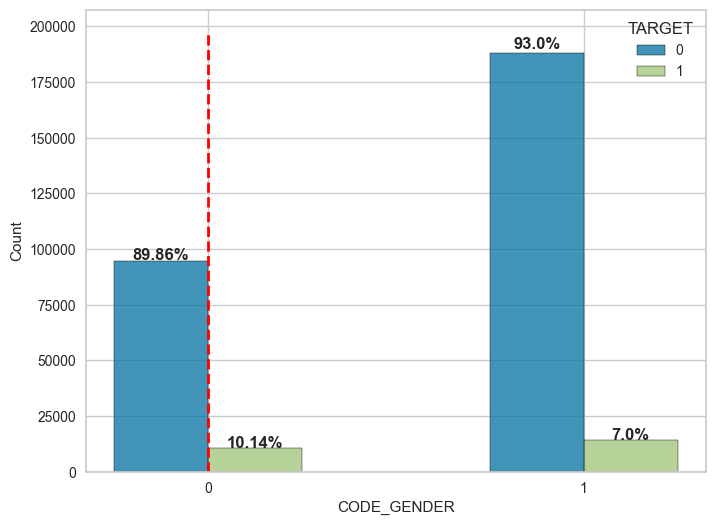

In [67]:
fig, ax = plt.subplots(figsize=(8, 6))

data = train_df[['CODE_GENDER', 'TARGET']]
sns.histplot(data=data, ax=ax, x='CODE_GENDER', hue='TARGET', multiple='dodge', discrete=True, shrink=0.5)
ax.set_xticks([0, 1])

a = [p.get_height() for p in ax.patches]
pourcentage = [a[0]/(a[0] + a[2]), a[1]/(a[1] + a[3]), a[2]/(a[0] + a[2]), a[3]/(a[1] + a[3])]
pourcentage = [np.round(100*i, 2) for i in pourcentage]

for i, p in enumerate(ax.patches):
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
     
    plt.text(x+width/2,
             y+height*1.01,
             str(pourcentage[i])+'%',
             ha='center',
             weight='bold')

y = ax.get_ylim()
x = X_test_df['CODE_GENDER']
plt.plot([x, x], y,
         color="red", lw=2, linestyle="--", 
         label='Valeur Client')
# pouvoir choisir quelle variable plot, et sur quel jeu de donnée (tout ou un cluster lié au client)

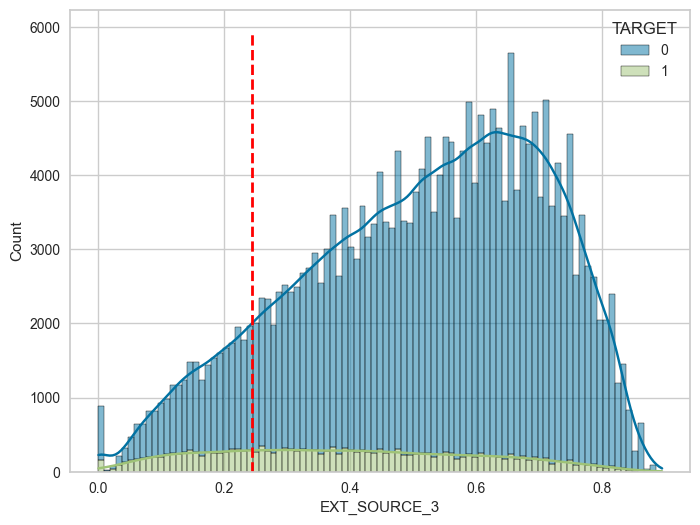

In [68]:
fig, ax = plt.subplots(figsize=(8, 6))

data = train_df[['EXT_SOURCE_3', 'TARGET']]
sns.histplot(data=data, ax=ax, x='EXT_SOURCE_3', hue='TARGET', multiple='stack', kde=True)

y = ax.get_ylim()
x = X_test.iloc[idx]['EXT_SOURCE_3']
plt.plot([x, x], y,
         color="red", lw=2, linestyle="--", 
         label='Valeur Client')

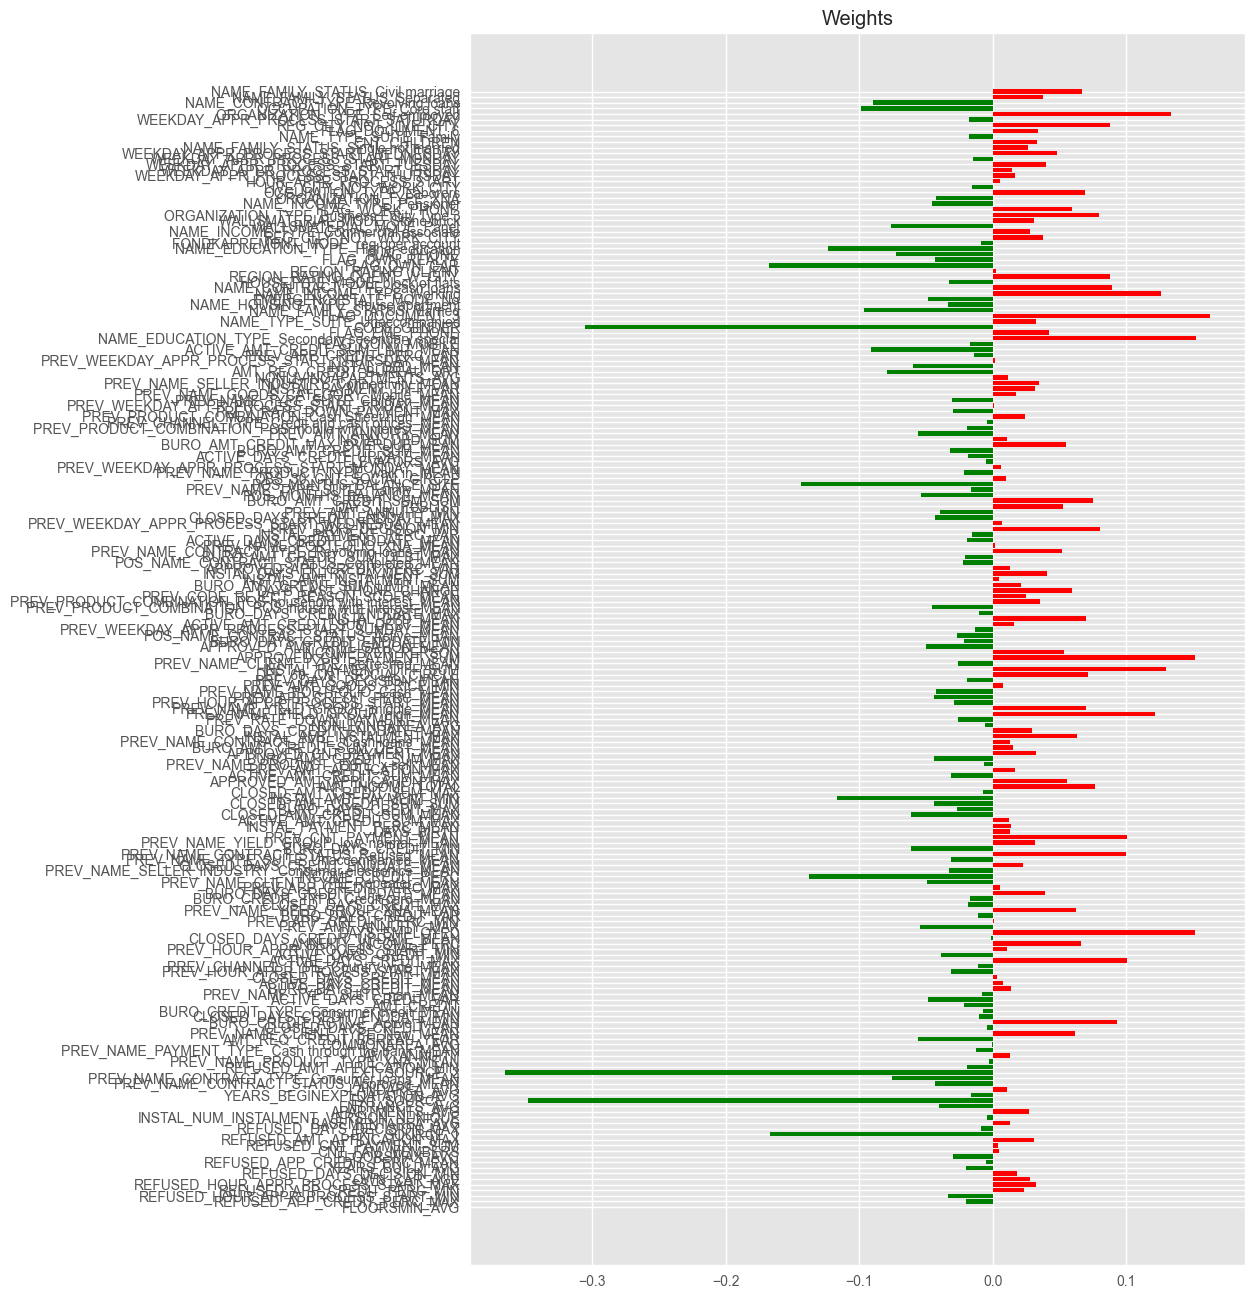

In [26]:
coefs = grid.best_estimator_['estimator'].coef_[0]
with plt.style.context("ggplot"):
    fig = plt.figure(figsize=(10,16))
    plt.barh(range(len(coefs)), coefs, color=["red" if coef>0 else "green" for coef in coefs])
    plt.yticks(range(len(coefs)), feature_names);
    plt.title("Weights")

# Light Gradient Boosting Model (LGBM)

## Sélection hyperparamètres avec GridSearch

In [27]:
# def custom_scorer(y_true, y_proba):
#     th = 0.085
#     y_pred = (y_proba > th).astype(int)
#     return 'f10', fbeta_score(y_true, y_pred, beta=10), True

In [28]:
X_t, X_v, y_t, y_v = train_test_split(X_train, y_train,
                                      stratify=y_train,
                                      train_size = 0.8,
                                      random_state = 42)

In [29]:
param_grid = {
    'n_estimators': [5000],
    'learning_rate': [0.02],
    'scale_pos_weight': [1, 5, 10]
}

param_fit = {
    'early_stopping_rounds': 200,
    'eval_metric': 'auc',
    'eval_set' : [(X_v, y_v)],
    'verbose': 100
}
    

clf = LGBMClassifier(
    max_depth=8,
    num_leaves=31,
    colsample_bytree=0.85,
    subsample=0.8715623,
    subsample_freq=5,
    reg_alpha=0.041545473,
    reg_lambda=0.0735294,
    min_split_gain=0.05,
    min_child_weight=39.3259775
)

cv = StratifiedKFold(n_splits=5)
grid = GridSearchCV(clf, param_grid=param_grid, cv=cv, scoring=scoring, refit='AUC')

In [30]:
print('Entrainement du modèle...')
start = time.time()
grid.fit(X_t, y_t, **param_fit)
end = time.time()
delta = round((end - start), 3)
print('Temps total CV : {}s'.format(delta))

Entrainement du modèle...


C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's auc: 0.753008	valid_0's binary_logloss: 0.250067
[200]	valid_0's auc: 0.766812	valid_0's binary_logloss: 0.244298
[300]	valid_0's auc: 0.772391	valid_0's binary_logloss: 0.242045
[400]	valid_0's auc: 0.775367	valid_0's binary_logloss: 0.240955
[500]	valid_0's auc: 0.776497	valid_0's binary_logloss: 0.240516
[600]	valid_0's auc: 0.77773	valid_0's binary_logloss: 0.240087
[700]	valid_0's auc: 0.77829	valid_0's binary_logloss: 0.239913
[800]	valid_0's auc: 0.778613	valid_0's binary_logloss: 0.239803
[900]	valid_0's auc: 0.778778	valid_0's binary_logloss: 0.239748
[1000]	valid_0's auc: 0.778824	valid_0's binary_logloss: 0.239739
[1100]	valid_0's auc: 0.778955	valid_0's binary_logloss: 0.239692
[1200]	valid_0's auc: 0.778989	valid_0's binary_logloss: 0.239723


C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's auc: 0.752752	valid_0's binary_logloss: 0.250109
[200]	valid_0's auc: 0.767333	valid_0's binary_logloss: 0.24425
[300]	valid_0's auc: 0.772782	valid_0's binary_logloss: 0.24196
[400]	valid_0's auc: 0.775639	valid_0's binary_logloss: 0.240828
[500]	valid_0's auc: 0.776978	valid_0's binary_logloss: 0.240328
[600]	valid_0's auc: 0.77753	valid_0's binary_logloss: 0.240097
[700]	valid_0's auc: 0.778042	valid_0's binary_logloss: 0.239909
[800]	valid_0's auc: 0.778711	valid_0's binary_logloss: 0.239704
[900]	valid_0's auc: 0.778958	valid_0's binary_logloss: 0.239642
[1000]	valid_0's auc: 0.778772	valid_0's binary_logloss: 0.239696
[1100]	valid_0's auc: 0.778984	valid_0's binary_logloss: 0.23967


C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's auc: 0.753353	valid_0's binary_logloss: 0.24993
[200]	valid_0's auc: 0.766962	valid_0's binary_logloss: 0.244261
[300]	valid_0's auc: 0.772288	valid_0's binary_logloss: 0.242056
[400]	valid_0's auc: 0.775087	valid_0's binary_logloss: 0.24095
[500]	valid_0's auc: 0.776709	valid_0's binary_logloss: 0.240381
[600]	valid_0's auc: 0.77756	valid_0's binary_logloss: 0.240062
[700]	valid_0's auc: 0.77805	valid_0's binary_logloss: 0.239913
[800]	valid_0's auc: 0.778629	valid_0's binary_logloss: 0.23973
[900]	valid_0's auc: 0.778914	valid_0's binary_logloss: 0.239663
[1000]	valid_0's auc: 0.779352	valid_0's binary_logloss: 0.239556
[1100]	valid_0's auc: 0.779359	valid_0's binary_logloss: 0.239553
[1200]	valid_0's auc: 0.779146	valid_0's binary_logloss: 0.239611


C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's auc: 0.753383	valid_0's binary_logloss: 0.249954
[200]	valid_0's auc: 0.767019	valid_0's binary_logloss: 0.244294
[300]	valid_0's auc: 0.772754	valid_0's binary_logloss: 0.242058
[400]	valid_0's auc: 0.775321	valid_0's binary_logloss: 0.241036
[500]	valid_0's auc: 0.776701	valid_0's binary_logloss: 0.240519
[600]	valid_0's auc: 0.777729	valid_0's binary_logloss: 0.240175
[700]	valid_0's auc: 0.778277	valid_0's binary_logloss: 0.24001
[800]	valid_0's auc: 0.778578	valid_0's binary_logloss: 0.239947
[900]	valid_0's auc: 0.778869	valid_0's binary_logloss: 0.239855
[1000]	valid_0's auc: 0.779244	valid_0's binary_logloss: 0.239777
[1100]	valid_0's auc: 0.779096	valid_0's binary_logloss: 0.239838


C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's auc: 0.753337	valid_0's binary_logloss: 0.249851
[200]	valid_0's auc: 0.767571	valid_0's binary_logloss: 0.244109
[300]	valid_0's auc: 0.773207	valid_0's binary_logloss: 0.241811
[400]	valid_0's auc: 0.77655	valid_0's binary_logloss: 0.240618
[500]	valid_0's auc: 0.778269	valid_0's binary_logloss: 0.240007
[600]	valid_0's auc: 0.779286	valid_0's binary_logloss: 0.239632
[700]	valid_0's auc: 0.779777	valid_0's binary_logloss: 0.239493
[800]	valid_0's auc: 0.78046	valid_0's binary_logloss: 0.23924
[900]	valid_0's auc: 0.780438	valid_0's binary_logloss: 0.239216
[1000]	valid_0's auc: 0.780348	valid_0's binary_logloss: 0.239242


C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's auc: 0.76028	valid_0's binary_logloss: 0.343738
[200]	valid_0's auc: 0.769885	valid_0's binary_logloss: 0.35774


C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's auc: 0.760872	valid_0's binary_logloss: 0.343288
[200]	valid_0's auc: 0.770267	valid_0's binary_logloss: 0.356928


C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's auc: 0.759944	valid_0's binary_logloss: 0.34304
[200]	valid_0's auc: 0.769082	valid_0's binary_logloss: 0.356901


C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's auc: 0.759946	valid_0's binary_logloss: 0.343409
[200]	valid_0's auc: 0.769894	valid_0's binary_logloss: 0.357092


C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's auc: 0.759947	valid_0's binary_logloss: 0.343007
[200]	valid_0's auc: 0.769569	valid_0's binary_logloss: 0.357008


C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's auc: 0.759358	valid_0's binary_logloss: 0.470484
[200]	valid_0's auc: 0.769089	valid_0's binary_logloss: 0.509198


C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's auc: 0.759407	valid_0's binary_logloss: 0.470125
[200]	valid_0's auc: 0.76912	valid_0's binary_logloss: 0.508174


C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's auc: 0.758513	valid_0's binary_logloss: 0.469528
[200]	valid_0's auc: 0.76786	valid_0's binary_logloss: 0.508025


C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's auc: 0.757534	valid_0's binary_logloss: 0.469941
[200]	valid_0's auc: 0.768229	valid_0's binary_logloss: 0.50786


C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's auc: 0.759801	valid_0's binary_logloss: 0.468647
[200]	valid_0's auc: 0.769488	valid_0's binary_logloss: 0.507258


C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\julie\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's auc: 0.753268	valid_0's binary_logloss: 0.250063
[200]	valid_0's auc: 0.767948	valid_0's binary_logloss: 0.244205
[300]	valid_0's auc: 0.773556	valid_0's binary_logloss: 0.241832
[400]	valid_0's auc: 0.776844	valid_0's binary_logloss: 0.240593
[500]	valid_0's auc: 0.778557	valid_0's binary_logloss: 0.239938
[600]	valid_0's auc: 0.779751	valid_0's binary_logloss: 0.239497
[700]	valid_0's auc: 0.780387	valid_0's binary_logloss: 0.239241
[800]	valid_0's auc: 0.780842	valid_0's binary_logloss: 0.239048
[900]	valid_0's auc: 0.781354	valid_0's binary_logloss: 0.238903
[1000]	valid_0's auc: 0.781743	valid_0's binary_logloss: 0.238777
[1100]	valid_0's auc: 0.781822	valid_0's binary_logloss: 0.23875
[1200]	valid_0's auc: 0.781796	valid_0's binary_logloss: 0.238784
Temps total CV : 339.308s


## Evaluation du modèle

In [31]:
b_score = grid.best_score_
b_params = grid.best_params_
print('Résultat sur le jeu d\'entrainement avec cross-validation')
print('Meilleur score : {}'.format(b_score))
print('Meilleur params : {}'.format(b_params))

Résultat sur le jeu d'entrainement avec cross-validation
Meilleur score : 0.7804719725450299
Meilleur params : {'learning_rate': 0.02, 'n_estimators': 5000, 'scale_pos_weight': 1}


In [32]:
cv_results = pd.DataFrame(grid.cv_results_)
cv_results

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      37.429065      2.658295         1.534910        0.284825   
1       9.528482      0.383719         0.310001        0.012820   
2       9.272979      0.427599         0.309536        0.017286   

  param_learning_rate param_n_estimators param_scale_pos_weight  \
0                0.02               5000                      1   
1                0.02               5000                      5   
2                0.02               5000                     10   

                                              params  split0_test_AUC  \
0  {'learning_rate': 0.02, 'n_estimators': 5000, ...         0.785711   
1  {'learning_rate': 0.02, 'n_estimators': 5000, ...         0.738599   
2  {'learning_rate': 0.02, 'n_estimators': 5000, ...         0.727133   

   split1_test_AUC  split2_test_AUC  split3_test_AUC  split4_test_AUC  \
0         0.784508         0.779916         0.776690         0.775535   
1         0.736005         0.733325         0.731521         0.725728   
2         0.724771         0.725551         0.722382         0.717920   

   mean_test_AUC  std_test_AUC  rank_test_AUC  split0_test_AP_score  \
0       0.780472      0.004067              1              0.272615   
1       0.733035      0.004371              2              0.216354   
2       0.723551      0.003206              3              0.195277   

   split1_test_AP_score  split2_test_AP_score  split3_test_AP_score  \
0              0.271918              0.263722              0.267567   
1              0.210164              0.201939              0.207868   
2              0.187444              0.184951              0.197276   

   split4_test_AP_score  mean_test_AP_score  std_test_AP_score  \
0              0.261138            0.267392           0.004481   
1              0.202547            0.207774           0.005305   
2              0.184713            0.189932           0.005305   

   rank_test_AP_score  split0_test_f1_score  split1_test_f1_score  \
0                   1              0.074312              0.060516   
1                   2              0.000000              0.000000   
2                   3              0.000000              0.000000   

   split2_test_f1_score  split3_test_f1_score  split4_test_f1_score  \
0              0.071596              0.078431              0.072834   
1              0.000000              0.000000              0.000000   
2              0.000000              0.000000              0.000000   

   mean_test_f1_score  std_test_f1_score  rank_test_f1_score  \
0            0.071538           0.005973                   1   
1            0.000000           0.000000                   2   
2            0.000000           0.000000                   2   

   split0_test_f10_score  split1_test_f10_score  split2_test_f10_score  \
0               0.040344               0.032397               0.038757   
1               0.000000               0.000000               0.000000   
2               0.000000               0.000000               0.000000   

   split3_test_f10_score  split4_test_f10_score  mean_test_f10_score  \
0               0.042568               0.039393             0.038692   
1               0.000000               0.000000             0.000000   
2               0.000000               0.000000             0.000000   

   std_test_f10_score  rank_test_f10_score  split0_test_accuracy  \
0            0.003402                    1              0.919612   
1            0.000000                    2              0.919281   
2            0.000000                    2              0.919281   

   split1_test_accuracy  split2_test_accuracy  split3_test_accuracy  \
0              0.919536              0.919610              0.919991   
1              0.919256              0.919279              0.919279   
2              0.919256              0.919279              0.919279   

   split4_test_accuracy  mean_test_accuracy  std_test_accuracy  \
0              

Résultat sur le jeu de test avec le meilleur modèle retenu


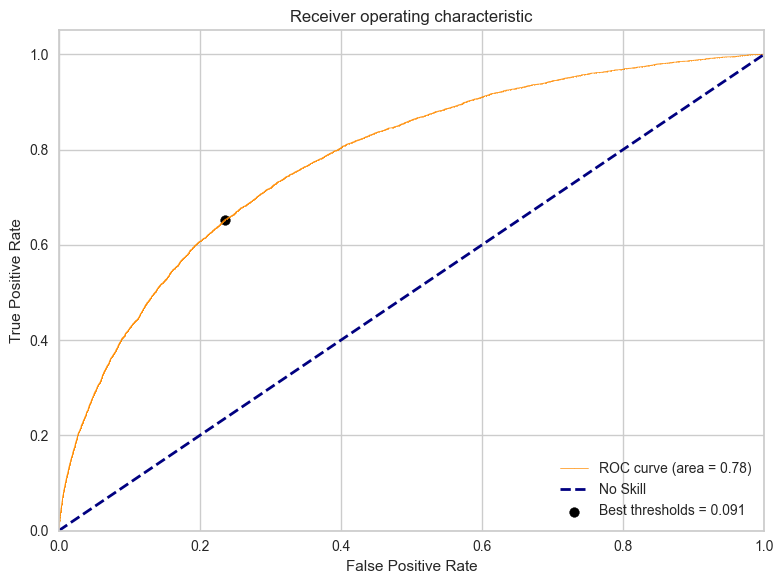

In [33]:
predictions = grid.predict_proba(X_test)[:, 1]

print('Résultat sur le jeu de test avec le meilleur modèle retenu')
best_thresh = utils.plot_roc_auc(y_test, predictions)

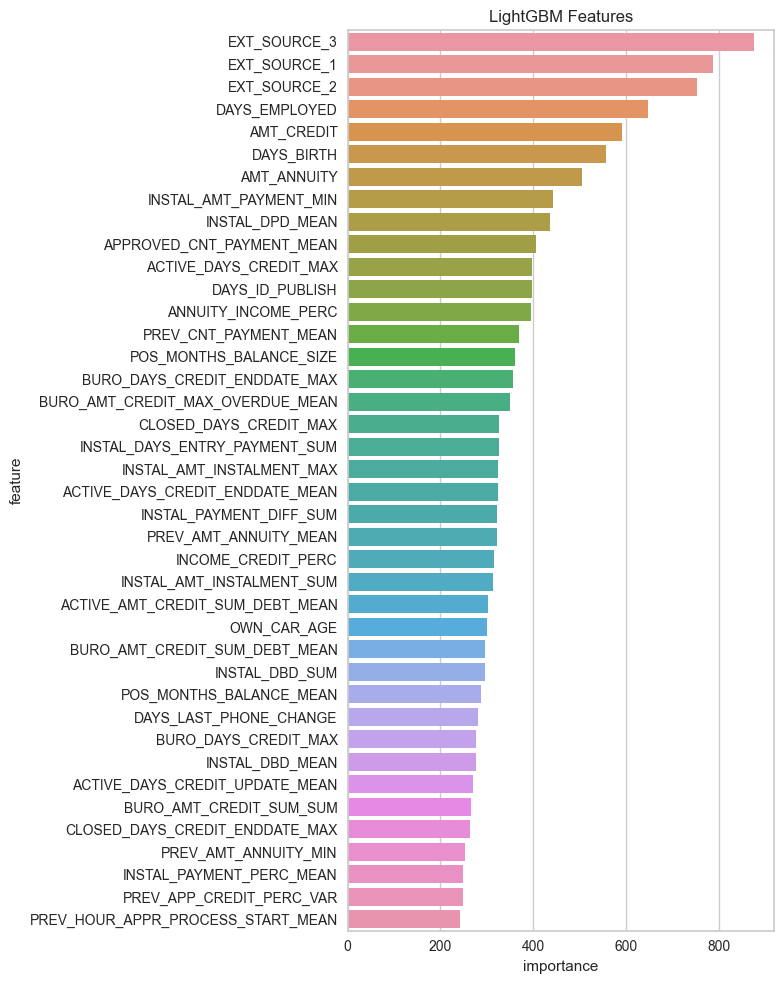

In [34]:
importance_df = pd.DataFrame()
importance_df["feature"] = feats
importance_df["importance"] = np.abs(grid.best_estimator_.feature_importances_)

title = 'LightGBM Features'
utils.display_importances(importance_df, title)

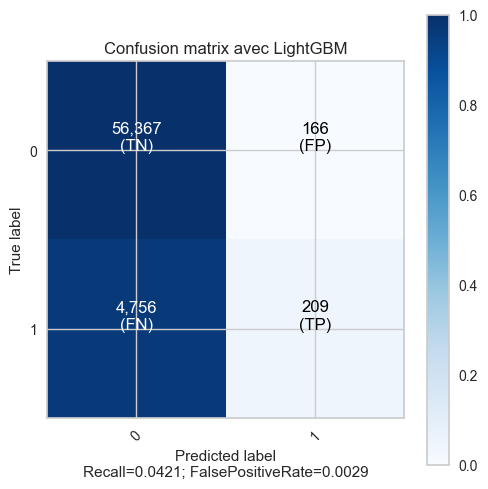

In [35]:
cm = confusion_matrix(y_test, grid.predict(X_test))
title = 'Confusion matrix avec LightGBM'
utils.plot_confusion_matrix(cm, ['0', '1'], title, normalize=True)

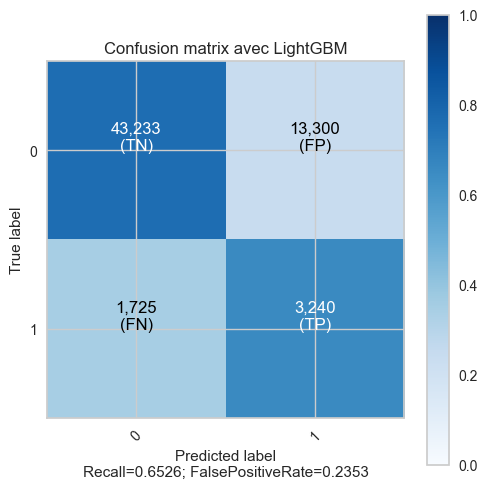

In [36]:
pred_threshed = []
for y in grid.predict_proba(X_test)[:, 1]:
    p = 0
    if y > best_thresh :
        p = 1
    pred_threshed.append(p)

cm = confusion_matrix(y_test, pred_threshed)
title = 'Confusion matrix avec LightGBM'
utils.plot_confusion_matrix(cm, ['0', '1'], title, normalize=True)

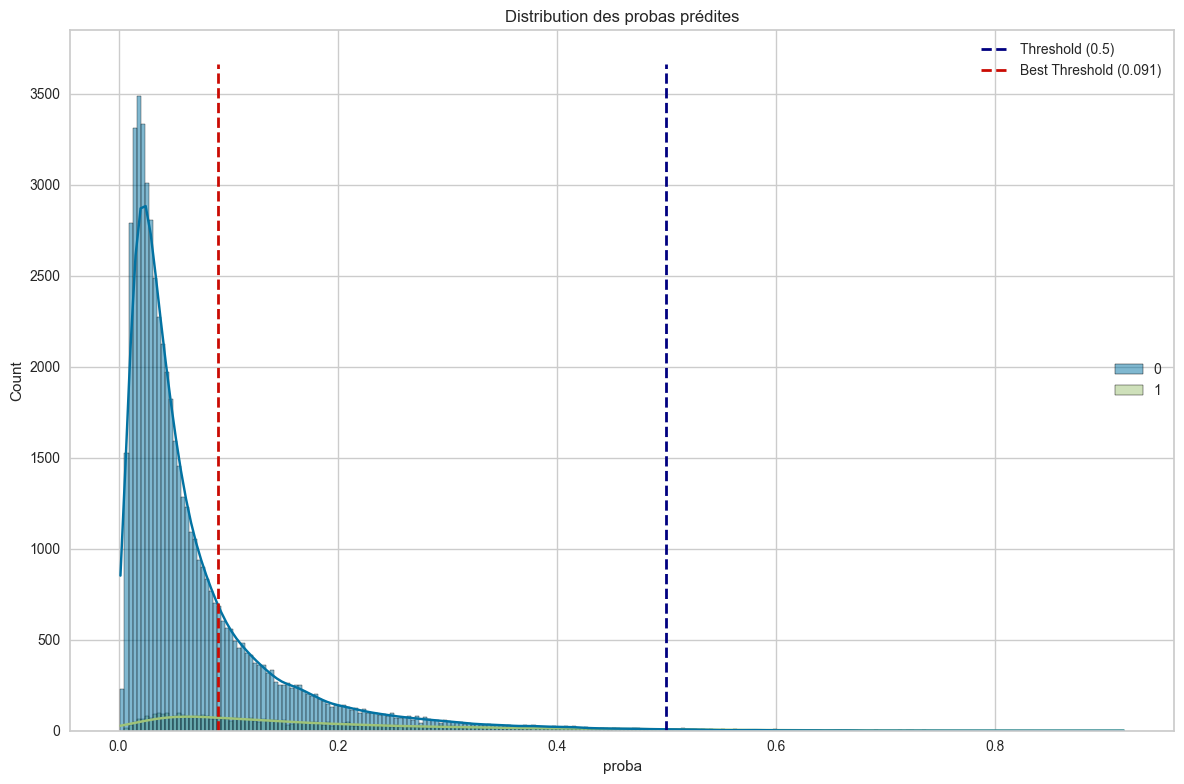

In [37]:
utils.plot_hist_proba(predictions, y_test, best_thresh)

## Enregistrement params/metrics/artefacts avec MLFlow

In [38]:
lgbm = LGBMClassifier(
        max_depth=8,
        num_leaves=31,
        colsample_bytree=0.85,
        subsample=0.8715623,
        subsample_freq=5,
        reg_alpha=0.041545473,
        reg_lambda=0.0735294,
        min_split_gain=0.05,
        min_child_weight=39.3259775,
        **b_params)

C:\Users\julie\anaconda3\lib\site-packages\mlflow\models\signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
C:\Users\julie\anaconda3\lib\site-packages\mlflow\models\signature.py:153: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data con

[100]	valid_0's auc: 0.753268	valid_0's binary_logloss: 0.250063
[200]	valid_0's auc: 0.767948	valid_0's binary_logloss: 0.244205
[300]	valid_0's auc: 0.773556	valid_0's binary_logloss: 0.241832
[400]	valid_0's auc: 0.776844	valid_0's binary_logloss: 0.240593
[500]	valid_0's auc: 0.778557	valid_0's binary_logloss: 0.239938
[600]	valid_0's auc: 0.779751	valid_0's binary_logloss: 0.239497
[700]	valid_0's auc: 0.780387	valid_0's binary_logloss: 0.239241
[800]	valid_0's auc: 0.780842	valid_0's binary_logloss: 0.239048
[900]	valid_0's auc: 0.781354	valid_0's binary_logloss: 0.238903
[1000]	valid_0's auc: 0.781743	valid_0's binary_logloss: 0.238777
[1100]	valid_0's auc: 0.781822	valid_0's binary_logloss: 0.23875
[1200]	valid_0's auc: 0.781796	valid_0's binary_logloss: 0.238784


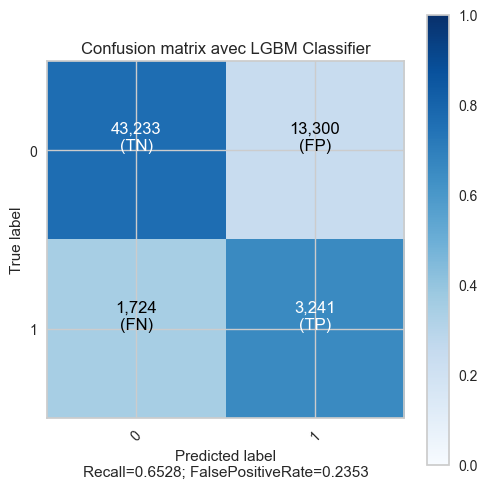

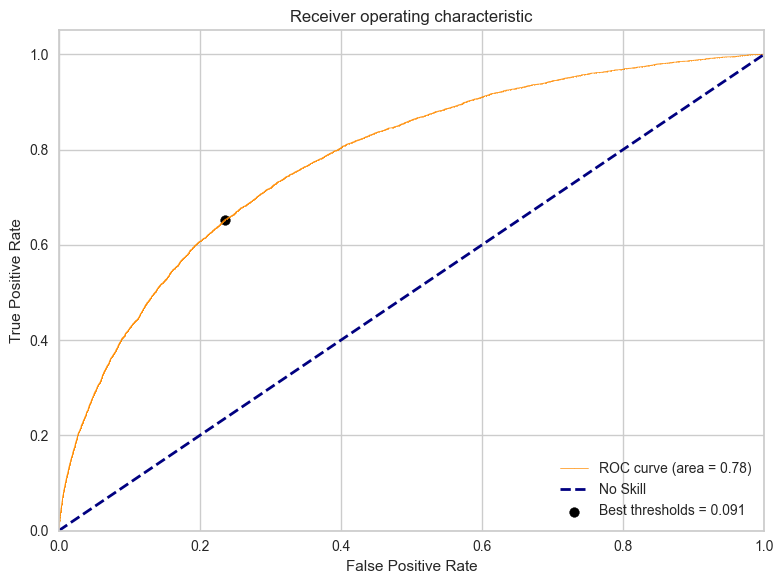

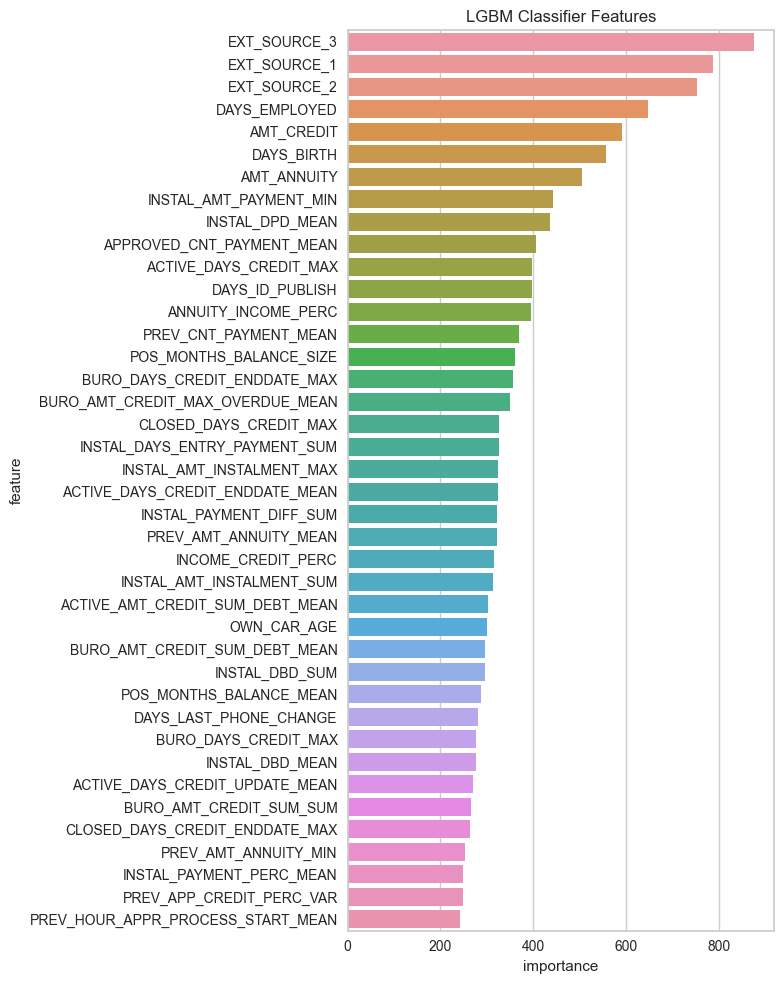

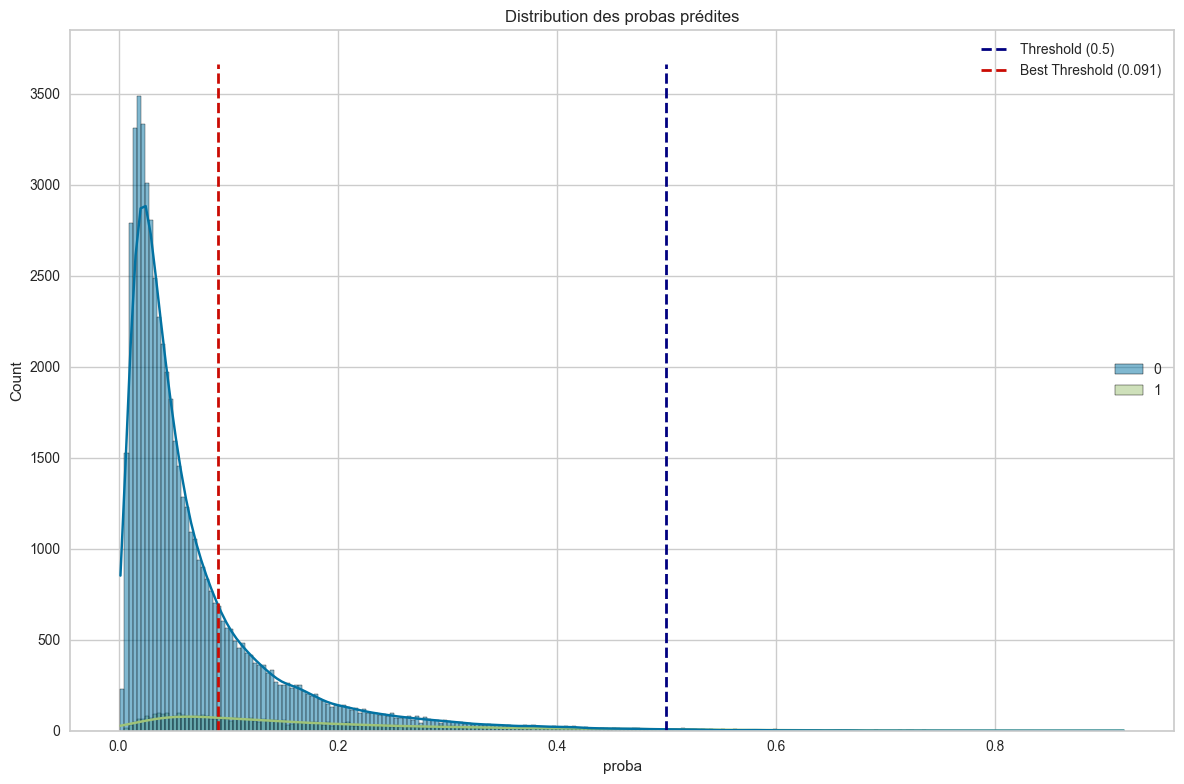

In [39]:
run_description = """
### Data
Dataset complet
Sélection de feature : condition sur la variance
                       Kbest (k=200) basé sur mutual_info_classif
                       corrélation entre variables

### Modèle
LightGBM paramétrer avec GridSearchCV
Threshold adapté au problème (cout FN = 10 * cout FP)
"""
run_name = 'LGBM'

with mlflow.start_run(run_name=run_name, description=run_description):

    # Enregistrement de plusieurs paramètres sous forme d'un dictionnaire
    params = {}
    params['MODEL_NAME'] = 'LGBMClassifier'
    params['PARAMS_CV'] = b_params
    params['THRESHOLD'] = best_thresh
    params['TRAIN_SIZE'] = len(X_train)
    params['TEST_SIZE'] = len(X_test)
    params['SEED'] = 42
    mlflow.log_params(params)

    # On note le moment du début de l'expérience pour mesurer la durée de l'entraînement
    start = time.time()

    # Initialisation du modèle
    lgbm = LGBMClassifier(
        max_depth=8,
        num_leaves=31,
        colsample_bytree=0.85,
        subsample=0.8715623,
        subsample_freq=5,
        reg_alpha=0.041545473,
        reg_lambda=0.0735294,
        min_split_gain=0.05,
        min_child_weight=39.3259775,
        **b_params
    )

    signature = infer_signature(X_train, y_train)

    # Entraînement du modèle
    param_fit = {
    'early_stopping_rounds': 200,
    'eval_metric': 'auc',
    'eval_set' : [(X_v, y_v)],
    'verbose': 100
    }
    lgbm.fit(X_t, y_t, **param_fit)

    training_time = time.time() - start

    # # Enregistrement du modèle
    
    # Appliquons le seuil de prédiction souhaité avec fonction personnalisée
    custom_threshold = best_thresh
    custom_model = CustomModelWrapper(lgbm, threshold=custom_threshold)
    
    predictions = custom_model.predict(None, X_test)
    predictions_proba = lgbm.predict_proba(X_test)[:, 1]

    # Enregistrez le modèle avec le seuil ajusté dans MLflow
    mlflow.pyfunc.log_model(
    python_model=custom_model,  
    artifact_path="mlflow_LR_with_threshold",  
    signature=signature
    )
    
    # # Enregistrement du modèle avec joblib
    # joblib.dump(lgbm, 'flask_application/model.joblib')

    # Enregistrement de plusieurs métriques sous forme d'un dictionnaire
    metrics = {}
    metrics['Auc'] = roc_auc_score(y_test, predictions_proba)
    metrics['Fbeta'] = fbeta_score(y_test, predictions, beta=10)
    metrics['Precision'] = precision_score(y_test, predictions)
    metrics['Recall'] = recall_score(y_test, predictions)
    metrics['Accuracy'] = accuracy_score(y_test, predictions)
    metrics['Training Time'] = training_time
    mlflow.log_metrics(metrics)

    # Enregistrement de la matrice de confusion
    cm = confusion_matrix(y_test, predictions)
    title = 'Confusion matrix avec LGBM Classifier'
    utils.plot_confusion_matrix(cm, ['0', '1'], title)
    mlflow.log_artifact('Data/matrix.png')

    # Enregistrement courbe ROC
    utils.plot_roc_auc(y_test, predictions_proba)
    mlflow.log_artifact('Data/roc_auc_curve.png')

    # Enregistrement features importance du modèle
    importance_df = pd.DataFrame()
    importance_df["feature"] = feats
    importance_df["importance"] = np.abs(lgbm.feature_importances_)

    title = 'LGBM Classifier Features'
    utils.display_importances(importance_df, title)
    mlflow.log_artifact('Data/features_importances.png')

    # # Enregistrement Learning curve
    # utils.plot_learning_curve(X_t, y_t, pred_pipeline)
    # mlflow.log_artifact('Data/learning_curve.png')
    
    # Enregistrement disribution probas
    utils.plot_hist_proba(predictions_proba, y_test, best_thresh)
    mlflow.log_artifact('Data/distribution_pred_probas.png')
    
    # # Enregistrement des datasets train et test
    # artifact_df(X_train, y_train, X_test, y_test, feats)
    # mlflow.log_artifact('train_data.csv')
    # mlflow.log_artifact('test_data.csv')
      

# Selection et sauvegarde du modèle

Via mlflow ui pour comparer nos différents modèles

In [74]:
# Selection du modèle via mlflow ou modèle actuel directement
MODEL_URI = 'runs:/7ab8205285294cc8a6427ce3a5e23a4a/mlflow_LR_with_threshold'
loaded_model = mlflow.pyfunc.load_model(model_uri=MODEL_URI)
unwrapped_model = loaded_model.unwrap_python_model()

# Enregistrement du modèle avec joblib
joblib.dump(unwrapped_model, 'flask_application/model.joblib')

['flask_application/model.joblib']

In [79]:
unwrapped_model.predict_proba(X_test.iloc[[idx]])[0]

array([0.34000549, 0.65999451])

In [80]:
testing_model = joblib.load('flask_application/model.joblib')

In [83]:
testing_model.predict(None, X_test.iloc[[idx]])[0]

1